In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from nilearn.connectome import sym_matrix_to_vec
from scipy.stats import pearsonr
from cmath import isinf
import torch.nn.functional as F
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pandas as pd
import math
from cmath import isinf
from sklearn.model_selection import train_test_split, KFold, LearningCurveDisplay, learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import multiprocessing
from skorch import NeuralNet

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def loader_to_numpy(loader):
    features, targets = [], []
    for feat, targ in loader:
        features.append(feat.numpy())
        targets.append(targ.numpy())
    return np.concatenate(features), np.concatenate(targets)

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim_feat = 499500, input_dim_target = 1, hidden_dim_feat = 1000, output_dim = 2, dropout_rate = 0):
        super(MLP, self).__init__()
        
        # Xavier initialization for feature MLP
        self.feat_mlp = nn.Sequential(
            nn.BatchNorm1d(input_dim_feat),
            nn.Linear(input_dim_feat, hidden_dim_feat),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim_feat, output_dim)
        )
        self.init_weights(self.feat_mlp)

        # Xavier initialization for target MLP
        self.target_mlp = nn.Sequential(
            nn.BatchNorm1d(input_dim_target),
            nn.Linear(input_dim_target, output_dim)
        )
        self.init_weights(self.target_mlp)
        
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.0)
        
    def forward(self, x, y):
        features = self.feat_mlp(x)
        targets = self.target_mlp(y)
        features = nn.functional.normalize(features, p=2, dim=1)
        targets = nn.functional.normalize(targets, p=2, dim=1)
        return features, targets

In [ ]:
class AgeEstimator(BaseEstimator):
    """ Define the age estimator on latent space network features.
    """
    def __init__(self):
        n_jobs = multiprocessing.cpu_count()
        self.age_estimator = GridSearchCV(
            Ridge(), param_grid={"alpha": 10.**np.arange(-2, 3)}, cv=5,
            scoring="r2", n_jobs=n_jobs)

    def fit(self, X, y):
        self.age_estimator.fit(X, y)
        return self.score(X, y), self.r2(X, y)

    def predict(self, X):
        y_pred = self.age_estimator.predict(X)
        return y_pred
    
    def score(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return mean_absolute_percentage_error(y, y_pred)
    
    def r2(self, X, y):
        y_pred = self.age_estimator.predict(X)
        return r2_score(y, y_pred)

In [5]:
class MatData(Dataset):
    def __init__(self, path_feat, path_target, target_name, transform = None, train=True, train_size = 0.8, test_size=None, test_site = None, regions = None, threshold_mat = False, threshold_percent = None, random_state=42):
        """
        Initializes the dataset with the capability to handle training and testing splits, 
        including multiple views for augmented data.
        
        Args:
            path_feat (str): Path to the features file.
            path_target (str): Path to the target file.
            transform (callable): A transformation function to apply for augmentation.
            train (bool): Whether the dataset is used for training. False will load the test set.
            test_size (float): Proportion of the dataset to include in the test split.
            random_state (int): Random state for reproducible train-test splits.
        """
        # Load the entire dataset
        features = np.load(path_feat)      
        participant_data = pd.read_csv(path_target)
        targets = np.expand_dims(participant_data[target_name].values, axis = 1)
        

        # Split the dataset into training and test sets
        if test_site is None:
            train_indices, test_indices = train_test_split(np.arange(len(features)), 
                                                       train_size = train_size,
                                                       test_size=test_size,                
                                                       random_state=random_state)
        else:
            test_indices = participant_data.index[participant_data['dataset'] == test_site].values
            train_indices = np.delete(np.arange(len(features)), test_indices)
        
        if train:
            selected_indices = train_indices
        else:
            selected_indices = test_indices
        
        # Select the subset of data for the current mode (train/test)
        features = features[selected_indices]
        if threshold_mat:
            thresholded_feat = []
            for matrix in features:
                threshold = np.percentile(matrix, threshold_percent)
                matrix[matrix < threshold] = 0
                thresholded_feat.append(matrix)
            threshold_feat = np.stack(thresholded_feat)
            features = threshold_feat
        targets = targets[selected_indices]
        

        self.n_sub = len(features)
        self.n_views = 1
        self.transform = transform
        self.targets = targets
        
        vectorized_feat = np.array([sym_matrix_to_vec(mat, discard_diagonal=True) for mat in features])
        self.n_features = vectorized_feat.shape[-1]
        
        if (train and transform is not None):
            # augmentation only in training mode
            if transform != "copy":
                augmented_features = np.array([self.transform(sample, regions = regions) for sample in features])

                self.n_views = self.n_views + augmented_features.shape[1]
                self.features = np.zeros((self.n_sub, self.n_views, self.n_features))
                for sub in range(self.n_sub):
                    self.features[sub, 0, :] = vectorized_feat[sub]
                    self.features[sub, 1:, :] = augmented_features[sub]
            else:
                self.features = np.repeat(np.expand_dims(vectorized_feat, axis = 1), 2, axis=1)
        else:
            self.features = np.expand_dims(vectorized_feat, axis = 1)
            
    def __len__(self):
        return self.n_sub

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        features = torch.from_numpy(features).float()
        targets = torch.from_numpy(targets).float()
        
        return features, targets

In [6]:
class CustomNet(NeuralNet):
    def __init__(self, module, train_data, estimator, criterion_pft=None, criterion_ptt=None, n_views = None, **kwargs):
        super(CustomNet, self).__init__(module, **kwargs)
        self.criterion_pft_cls = criterion_pft
        self.criterion_ptt_cls = criterion_ptt
        self.n_views = n_views
        slef.estimator = estimator
        self.train_data = train_data

    def initialize_criterion(self):
        super().initialize_criterion()  # Initialize default criterion first
        # Setup custom criterion with parameters from get_params_for
        if self.criterion_pft_cls is not None:
            self.criterion_pft_ = self.criterion_pft_cls(**self.get_params_for('criterion_pft'))
        if self.criterion_ptt_cls is not None:
            self.criterion_ptt_ = self.criterion_ptt_cls(**self.get_params_for('criterion_ptt'))
        return self
    
    def train_step_single(self, batch, **fit_params):
        self.module_.train()
        features, targets = batch
        features, targets = features.to(self.device), targets.to(self.device)
        self.optimizer_.zero_grad()
        mlp_out = self.module_(features, targets)  # Pass both Xi and yi to forward
        loss = self.get_loss(mlp_out, targets, training=True)
        loss.backward()
        self.optimizer_.step()
        return {'loss': loss}
    
    def validation_step(self, batch, **fit_params):
        self.module_.eval()  # Set the module in evaluation mode
        features, targets = batch
        with torch.no_grad():
            features, targets = features.to(self.device), targets.to(self.device)
            out_feat, out_target = self.module_(features, targets)
        
        loss = self.get_loss((out_feat, out_target), targets, training=False)
        
        out_feat_train, _ = self.module_(self.train_data)
        self.estimator = self.estimator.fit(out_feat_train)
        y_pred = self.estimator.pred(out_feat)
        return {'loss': loss, 'y_pred': y_pred}

    def get_loss(self, mlp_out, targets, training=False):
        n_views = self.n_views
        out_feat, out_target = mlp_out
        bsz = out_feat.shape[0]
        out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
        out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1)
        
        loss = self.criterion_pft_(out_feat, targets)
        out_target = torch.split(out_target, [bsz]*n_views, dim=0)
        out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1)
        
        loss += self.criterion_ptt_(out_target, targets)
        loss += torch.nn.functional.mse_loss(out_feat.view(bsz * n_views, 2), out_target.view(bsz * n_views, 2))
        return loss

In [7]:
def gaussian_kernel(x, krnl_sigma):
    x = x - x.T
    return torch.exp(-(x**2) / (2*(krnl_sigma**2))) / (math.sqrt(2*torch.pi)*krnl_sigma)

def cauchy(x, krnl_sigma):
        x = x - x.T
        return  1. / (krnl_sigma*(x**2) + 1)

def rbf(x, krnl_sigma):
        x = x - x.T
        return torch.exp(-(x**2)/(2*(krnl_sigma**2)))

In [8]:
# loss from: https://github.com/EIDOSLAB/contrastive-brain-age-prediction/blob/master/src/losses.py
# modified to accept input shape [bsz, n_feats]. In the age paper: [bsz, n_views, n_feats].
class KernelizedSupCon(nn.Module):
    """Supervised contrastive loss: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    Based on: https://github.com/HobbitLong/SupContrast"""
    def __init__(self, method: str='expw', temperature: float=0.03, contrast_mode: str='all',
                 base_temperature: float=0.07, krnl_sigma: float = 1., kernel: callable=cauchy, delta_reduction: str='sum'):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.method = method
        self.kernel = kernel
        self.krnl_sigma = krnl_sigma
        self.delta_reduction = delta_reduction

        if kernel is not None and method == 'supcon':
            raise ValueError('Kernel must be none if method=supcon')
        
        if kernel is None and method != 'supcon':
            raise ValueError('Kernel must not be none if method != supcon')

        if delta_reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction {delta_reduction}")

    def __repr__(self):
        return f'{self.__class__.__name__} ' \
               f'(t={self.temperature}, ' \
               f'method={self.method}, ' \
               f'kernel={self.kernel is not None}, ' \
               f'delta_reduction={self.delta_reduction})'

    def forward(self, features, labels=None):
        """Compute loss for model. If `labels` is None, 
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, n_features]. 
                input has to be rearranged to [bsz, n_views, n_features] and labels [bsz],
            labels: ground truth of shape [bsz].
        Returns:
            A loss scalar.
        """
        device = features.device

        if len(features.shape) != 3:
            raise ValueError('`features` needs to be [bsz, n_views, n_feats],'
                             '3 dimensions are required')

        batch_size = features.shape[0]
        contrast_count = features.shape[1]

        if labels is None:
            mask = torch.eye(batch_size, device=device)
        
        else:
            labels = labels.view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            
            if self.kernel is None:
                mask = torch.eq(labels, labels.T)
            else:
                mask = self.kernel(labels, krnl_sigma = self.krnl_sigma)     
        
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # Tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # Inverse of torch-eye to remove self-contrast (diagonal)
        inv_diagonal = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size*anchor_count, device=device).view(-1, 1),
            0
        )
        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature
        )

        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        alignment = logits 

        # base case is:
        # - supcon if kernel = none 
        # - y-aware is kernel != none
        uniformity = torch.exp(logits) * inv_diagonal 

        if self.method == 'threshold':
            repeated = mask.unsqueeze(-1).repeat(1, 1, mask.shape[0]) # repeat kernel mask

            delta = (mask[:, None].T - repeated.T).transpose(1, 2) # compute the difference w_k - w_j for every k,j
            delta = (delta > 0.).float()

            # for each z_i, repel only samples j s.t. K(z_i, z_j) < K(z_i, z_k)
            uniformity = uniformity.unsqueeze(-1).repeat(1, 1, mask.shape[0])

            if self.delta_reduction == 'mean':
                uniformity = (uniformity * delta).mean(-1)
            else:
                uniformity = (uniformity * delta).sum(-1)
    
        elif self.method == 'expw':
            # exp weight e^(s_j(1-w_j))
            uniformity = torch.exp(logits * (1 - mask)) * inv_diagonal

        uniformity = torch.log(uniformity.sum(1, keepdim=True))


        # positive mask contains the anchor-positive pairs
        # excluding <self,self> on the diagonal
        positive_mask = mask * inv_diagonal

        log_prob = alignment - uniformity # log(alignment/uniformity) = log(alignment) - log(uniformity)
        log_prob = (positive_mask * log_prob).sum(1) / positive_mask.sum(1) # compute mean of log-likelihood over positive
 
        # loss
        loss = - (self.temperature / self.base_temperature) * log_prob
        return loss.mean()

In [9]:
input_dim_feat = 499500 # vectorized mat, diagonal discarded
# the rest is arbitrary
hidden_dim_feat = 1000
input_dim_target = 1
output_dim = 2
num_epochs = 100

lr = 0.01 # too low values return nan loss
kernel = cauchy
batch_size = 30 # too low values return nan loss
dropout_rate = 0
weight_decay = 0

In [23]:
model = CustomNet(
    module=MLP,
    optimizer=optim.Adam,
    lr = 0.01,
    estimator = 
    module__input_dim_feat = 499500,
    module__hidden_dim_feat = 1000,
    module__input_dim_target = 1,
    module__output_dim = 2,
    n_views = 1,
    criterion_pft=KernelizedSupCon,
    criterion_ptt=KernelizedSupCon,
    criterion=torch.nn.MSELoss(),  # Default criterion, actual loss handled in get_loss
    batch_size=30,
    max_epochs=100,
    device='cuda',
)

In [11]:
from torch.utils.data import ConcatDataset

train_dataset = MatData("matrices.npy", "participants.csv", "age", train=True, test_size = 0.2)
test_dataset = MatData("matrices.npy", "participants.csv", "age", train=False, test_size = 0.2)
dataset = ConcatDataset([train_dataset, test_dataset])

dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle = False)
features, targets = loader_to_numpy(dataloader)

In [12]:
model.fit(X= features.squeeze(1),y =targets)

Loss:  16.319875717163086
Loss:  4.596426486968994
Loss:  3.674405097961426
Loss:  3.4993159770965576
Loss:  3.43544602394104
Loss:  3.053532600402832
Loss:  3.0746428966522217
Loss:  2.9442903995513916
Loss:  2.9357991218566895
Loss:  2.9062116146087646
Loss:  2.9092061519622803
Loss:  2.8639962673187256
Loss:  2.8776121139526367
Loss:  2.742440700531006
Loss:  3.0218026638031006
Loss:  2.970330238342285
Loss:  2.858966827392578
Loss:  2.7810487747192383
Loss:  2.8471286296844482
Loss:  2.7045159339904785
Loss:  2.7584352493286133
Loss:  2.6810054779052734
Loss:  2.711137294769287
Loss:  2.739959955215454
Loss:  2.6077935695648193
Loss:  2.7372987270355225
Loss:  2.8451695442199707
Loss:  2.6975162029266357
Loss:  2.8641114234924316
Loss:  2.7417733669281006
Loss:  2.7559664249420166
Loss:  1.5878994464874268
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        3.5431        2.7232  5.7686
Loss:  2.832012176513672
Loss:  2.853528261184

Loss:  2.5795435905456543
Loss:  2.57192325592041
Loss:  2.615762710571289
Loss:  2.6032114028930664
Loss:  2.5841941833496094
Loss:  2.632446765899658
Loss:  2.585608959197998
Loss:  2.6547462940216064
Loss:  2.651897430419922
Loss:  2.611384630203247
Loss:  2.6052494049072266
Loss:  2.631199598312378
Loss:  2.579848051071167
Loss:  2.611353874206543
Loss:  2.5598578453063965
Loss:  2.596311569213867
Loss:  2.593529224395752
Loss:  2.5126705169677734
Loss:  2.5967533588409424
Loss:  2.6618964672088623
Loss:  2.5693206787109375
Loss:  2.6484503746032715
Loss:  2.591674327850342
Loss:  2.5977542400360107
Loss:  1.5036251544952393
     10        2.6042        2.5639  5.2567
Loss:  2.6657156944274902
Loss:  2.666884183883667
Loss:  2.6108646392822266
Loss:  2.5971181392669678
Loss:  2.598935604095459
Loss:  2.5759499073028564
Loss:  2.5991759300231934
Loss:  2.579561948776245
Loss:  2.5716686248779297
Loss:  2.615569829940796
Loss:  2.6031641960144043
Loss:  2.584256410598755
Loss:  2.631

Loss:  2.6094839572906494
Loss:  2.55537748336792
Loss:  2.59454345703125
Loss:  2.5920093059539795
Loss:  2.511683940887451
Loss:  2.5909721851348877
Loss:  2.663954973220825
Loss:  2.5649912357330322
Loss:  2.6500110626220703
Loss:  2.587676525115967
Loss:  2.597801685333252
Loss:  1.514370083808899
     19        2.6012        2.5626  5.2068
Loss:  2.6490728855133057
Loss:  2.6677417755126953
Loss:  2.608059883117676
Loss:  2.5910778045654297
Loss:  2.598576545715332
Loss:  2.5776126384735107
Loss:  2.597564458847046
Loss:  2.5762557983398438
Loss:  2.5676376819610596
Loss:  2.6137399673461914
Loss:  2.60359263420105
Loss:  2.585139274597168
Loss:  2.624990701675415
Loss:  2.5814602375030518
Loss:  2.6539433002471924
Loss:  2.650153160095215
Loss:  2.5972228050231934
Loss:  2.6042370796203613
Loss:  2.628030776977539
Loss:  2.576568603515625
Loss:  2.6094117164611816
Loss:  2.5548453330993652
Loss:  2.594231605529785
Loss:  2.591885805130005
Loss:  2.511171579360962
Loss:  2.5906279

Loss:  2.63018536567688
Loss:  2.665879487991333
Loss:  2.5968315601348877
Loss:  2.57411527633667
Loss:  2.594536066055298
Loss:  2.576916217803955
Loss:  2.589357376098633
Loss:  2.5632712841033936
Loss:  2.558748722076416
Loss:  2.600233793258667
Loss:  2.5943775177001953
Loss:  2.585526466369629
Loss:  2.605700731277466
Loss:  2.5597612857818604
Loss:  2.641941785812378
Loss:  2.641030788421631
Loss:  2.5730855464935303
Loss:  2.604586601257324
Loss:  2.627293586730957
Loss:  2.57163143157959
Loss:  2.606182336807251
Loss:  2.547551393508911
Loss:  2.589047908782959
Loss:  2.5861406326293945
Loss:  2.4987411499023438
Loss:  2.5876359939575195
Loss:  2.6588168144226074
Loss:  2.5544419288635254
Loss:  2.6496822834014893
Loss:  2.590933084487915
Loss:  2.608894109725952
Loss:  1.5208929777145386
     29        2.5916        2.5621  5.2087
Loss:  2.6278345584869385
Loss:  2.6640145778656006
Loss:  2.5937180519104004
Loss:  2.5682373046875
Loss:  2.5927066802978516
Loss:  2.57625794410

Loss:  2.5978686809539795
Loss:  2.49448561668396
Loss:  2.451066732406616
Loss:  2.571578025817871
Loss:  2.5560872554779053
Loss:  2.4637680053710938
Loss:  2.530704975128174
Loss:  2.4481987953186035
Loss:  2.4562618732452393
Loss:  2.5237467288970947
Loss:  2.358001947402954
Loss:  2.56693696975708
Loss:  2.6245980262756348
Loss:  2.516566276550293
Loss:  2.609206199645996
Loss:  2.6659069061279297
Loss:  2.6880013942718506
Loss:  1.5148017406463623
     38        2.4990        2.5652  5.2040
Loss:  2.5399625301361084
Loss:  2.5731871128082275
Loss:  2.523909568786621
Loss:  2.5266027450561523
Loss:  2.451725721359253
Loss:  2.5030429363250732
Loss:  2.4455106258392334
Loss:  2.408345937728882
Loss:  2.38558292388916
Loss:  2.483330011367798
Loss:  2.433821439743042
Loss:  2.469761610031128
Loss:  2.38862681388855
Loss:  2.3889145851135254
Loss:  2.6059446334838867
Loss:  2.4842000007629395
Loss:  2.480173110961914
Loss:  2.560513973236084
Loss:  2.5562658309936523
Loss:  2.4527060

Loss:  2.471972703933716
Loss:  2.4983561038970947
Loss:  2.35562801361084
Loss:  2.430964708328247
Loss:  2.3822386264801025
Loss:  2.3107645511627197
Loss:  2.3756954669952393
Loss:  2.546065330505371
Loss:  2.348055362701416
Loss:  2.412824869155884
Loss:  2.3442580699920654
Loss:  2.342463254928589
Loss:  2.3679921627044678
Loss:  2.3296244144439697
Loss:  2.6773064136505127
Loss:  2.388216972351074
Loss:  2.3238489627838135
Loss:  2.4049549102783203
Loss:  2.4101974964141846
Loss:  2.4013288021087646
Loss:  2.3394715785980225
Loss:  2.33068585395813
Loss:  2.3113794326782227
Loss:  2.435678720474243
Loss:  2.226039409637451
Loss:  2.5323097705841064
Loss:  2.656672477722168
Loss:  2.5301432609558105
Loss:  2.800208568572998
Loss:  2.8849570751190186
Loss:  2.709252119064331
Loss:  1.679050326347351
     48        2.3911        2.6428  5.2045
Loss:  2.4472672939300537
Loss:  2.4837708473205566
Loss:  2.3735251426696777
Loss:  2.4069435596466064
Loss:  2.375098705291748
Loss:  2.304

Loss:  2.3358137607574463
Loss:  2.275320291519165
Loss:  2.2978718280792236
Loss:  2.259068250656128
Loss:  2.2853996753692627
Loss:  2.3258161544799805
Loss:  2.1587040424346924
Loss:  2.557488441467285
Loss:  2.6592037677764893
Loss:  2.5262091159820557
Loss:  2.756732225418091
Loss:  2.825770854949951
Loss:  2.6317696571350098
Loss:  1.6098250150680542
     57        2.2959        2.6149  5.2021
Loss:  2.4325966835021973
Loss:  2.4159746170043945
Loss:  2.2599587440490723
Loss:  2.3060524463653564
Loss:  2.2609312534332275
Loss:  2.23325777053833
Loss:  2.2669477462768555
Loss:  2.2120723724365234
Loss:  2.2345149517059326
Loss:  2.2979257106781006
Loss:  2.2456564903259277
Loss:  2.2326409816741943
Loss:  2.2842984199523926
Loss:  2.1960153579711914
Loss:  2.4671802520751953
Loss:  2.3770394325256348
Loss:  2.327894687652588
Loss:  2.3104500770568848
Loss:  2.322841167449951
Loss:  2.271162748336792
Loss:  2.287431478500366
Loss:  2.2524163722991943
Loss:  2.293501377105713
Loss: 

Loss:  2.2939279079437256
Loss:  2.2887935638427734
Loss:  2.2831716537475586
Loss:  2.3284740447998047
Loss:  2.414970636367798
Loss:  2.3177194595336914
Loss:  2.297443389892578
Loss:  2.3529646396636963
Loss:  2.262651205062866
Loss:  2.2787861824035645
Loss:  2.3341758251190186
Loss:  2.2800092697143555
Loss:  2.580751419067383
Loss:  2.4238154888153076
Loss:  2.3258414268493652
Loss:  2.289158821105957
Loss:  2.3128814697265625
Loss:  2.31844162940979
Loss:  2.3215270042419434
Loss:  2.3079802989959717
Loss:  2.2593071460723877
Loss:  2.2742691040039062
Loss:  2.1724159717559814
Loss:  2.570955514907837
Loss:  2.681983470916748
Loss:  2.54069185256958
Loss:  2.8854355812072754
Loss:  2.9272143840789795
Loss:  2.627913236618042
Loss:  1.716869592666626
     67        2.3330        2.6636  5.2037
Loss:  2.424791097640991
Loss:  2.4593286514282227
Loss:  2.2678394317626953
Loss:  2.3326025009155273
Loss:  2.27156925201416
Loss:  2.2174084186553955
Loss:  2.2611470222473145
Loss:  2.2

Loss:  2.28218674659729
Loss:  2.2320408821105957
Loss:  2.3358066082000732
Loss:  2.323315382003784
Loss:  2.358686923980713
Loss:  2.29892897605896
Loss:  2.1339035034179688
Loss:  2.5869710445404053
Loss:  2.6577887535095215
Loss:  2.5540077686309814
Loss:  2.830449342727661
Loss:  2.8594632148742676
Loss:  2.625839948654175
Loss:  1.620732069015503
     76        2.3039        2.6404  5.2297
Loss:  2.408897876739502
Loss:  2.3602559566497803
Loss:  2.2552530765533447
Loss:  2.270203113555908
Loss:  2.237344741821289
Loss:  2.209493637084961
Loss:  2.2480173110961914
Loss:  2.155914068222046
Loss:  2.2335190773010254
Loss:  2.3138954639434814
Loss:  2.2657124996185303
Loss:  2.243624687194824
Loss:  2.3049979209899902
Loss:  2.184227705001831
Loss:  2.41953182220459
Loss:  2.3654277324676514
Loss:  2.324700355529785
Loss:  2.343153953552246
Loss:  2.3964128494262695
Loss:  2.330152750015259
Loss:  2.276949882507324
Loss:  2.261324167251587
Loss:  2.2900543212890625
Loss:  2.33467817

Loss:  2.2246146202087402
Loss:  2.159473180770874
Loss:  2.2128899097442627
Loss:  2.1906609535217285
Loss:  2.238255262374878
Loss:  2.3061914443969727
Loss:  2.241861581802368
Loss:  2.177976369857788
Loss:  2.2729291915893555
Loss:  2.167855739593506
Loss:  2.4260966777801514
Loss:  2.405637502670288
Loss:  2.3387348651885986
Loss:  2.3038721084594727
Loss:  2.3078010082244873
Loss:  2.2105283737182617
Loss:  2.2578790187835693
Loss:  2.222001075744629
Loss:  2.293882131576538
Loss:  2.2743709087371826
Loss:  2.1226320266723633
Loss:  2.7125051021575928
Loss:  2.70800518989563
Loss:  2.6100380420684814
Loss:  2.9995040893554688
Loss:  3.024003028869629
Loss:  2.5893137454986572
Loss:  1.8123314380645752
     86        2.2686        2.7330  5.2081
Loss:  2.402958631515503
Loss:  2.3775956630706787
Loss:  2.19162917137146
Loss:  2.219033718109131
Loss:  2.209376096725464
Loss:  2.2191784381866455
Loss:  2.2572598457336426
Loss:  2.1623897552490234
Loss:  2.1851015090942383
Loss:  2.2

Loss:  2.2018518447875977
Loss:  2.248495578765869
Loss:  2.2356653213500977
Loss:  2.093773126602173
Loss:  2.7440991401672363
Loss:  2.6899936199188232
Loss:  2.627790689468384
Loss:  2.973659038543701
Loss:  3.0159757137298584
Loss:  2.584132194519043
Loss:  1.7975391149520874
     95        2.2624        2.7311  5.2505
Loss:  2.3937535285949707
Loss:  2.353971481323242
Loss:  2.1827340126037598
Loss:  2.2026708126068115
Loss:  2.200190544128418
Loss:  2.1910948753356934
Loss:  2.220478057861328
Loss:  2.13925838470459
Loss:  2.174239158630371
Loss:  2.2733535766601562
Loss:  2.206573724746704
Loss:  2.2051477432250977
Loss:  2.2946536540985107
Loss:  2.217290163040161
Loss:  2.411005735397339
Loss:  2.3974454402923584
Loss:  2.266340494155884
Loss:  2.243025064468384
Loss:  2.336850643157959
Loss:  2.273028612136841
Loss:  2.274599075317383
Loss:  2.2456319332122803
Loss:  2.194798231124878
Loss:  2.193359851837158
Loss:  2.0854671001434326
Loss:  2.8144567012786865
Loss:  2.824566

<class '__main__.CustomNet'>[initialized](
  module_=MLP(
    (feat_mlp): Sequential(
      (0): BatchNorm1d(499500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=499500, out_features=1000, bias=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
      (4): Linear(in_features=1000, out_features=2, bias=True)
    )
    (target_mlp): Sequential(
      (0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=1, out_features=2, bias=True)
    )
  ),
)

In [24]:
projection_age_estimator = ProjectionAgeEstimator(custom_net=model)


In [20]:
projection_age_estimator.fit(features.squeeze(1), targets)

Re-initializing module because the following parameters were re-set: hidden_dim_feat, input_dim_feat, input_dim_target, output_dim.
Re-initializing criterion.
Re-initializing optimizer.
Loss:  14.8409423828125
Loss:  6.3048295974731445
Loss:  4.309867858886719
Loss:  3.862704038619995
Loss:  3.8481736183166504
Loss:  3.4727208614349365
Loss:  3.6281301975250244
Loss:  3.440521001815796
Loss:  3.4281177520751953
Loss:  3.465547800064087
Loss:  3.4668784141540527
Loss:  3.3818492889404297
Loss:  3.383931875228882
Loss:  3.115739345550537
Loss:  3.5994744300842285
Loss:  3.4703662395477295
Loss:  3.2510499954223633
Loss:  3.0903844833374023
Loss:  3.1757078170776367
Loss:  2.95011305809021
Loss:  3.0272836685180664
Loss:  2.905761957168579
Loss:  2.9082469940185547
Loss:  2.9462461471557617
Loss:  2.7896568775177
Loss:  2.9061388969421387
Loss:  3.0662286281585693
Loss:  2.8704910278320312
Loss:  3.100492477416992
Loss:  2.8935303688049316
Loss:  2.968083143234253
Loss:  1.719470858573913

TypeError: forward() missing 1 required positional argument: 'y'

In [ ]:
model.fit(features, targets)

In [25]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator=projection_age_estimator,  # Your skorch wrapped model
    X=features.squeeze(1),  # Combined features
    y=targets,  # Ensure targets are in the correct shape
    scoring='r2'  # Example scoring metric
)

RuntimeError: Cannot clone object <class '__main__.CustomNet'>[uninitialized](
  module=<class '__main__.MLP'>,
  module__hidden_dim_feat=1000,
  module__input_dim_feat=499500,
  module__input_dim_target=1,
  module__output_dim=2,
), as the constructor either does not set or modifies parameter criterion_pft_cls

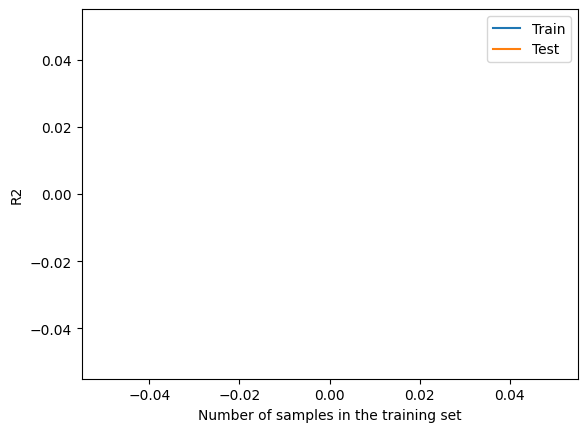

In [61]:
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="R2")
display.plot()
plt.show()

In [58]:
train_scores

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]])